# imports

In [15]:
%load_ext autoreload
%autoreload 2

import sys
import random
from tqdm import tqdm_notebook

sys.path.append("src")

from word_order.process_treebank import create_word_order_df, read_df

random.seed(42)

resource_dir = "resources"
word_order_dir = "/media/jaap/81b6ce8a-28e5-4eda-9c68-b13e0637cc4f/word_order_df/"

# langs = get_ud_langs("resources")

max_treebank_len = 30_000
langs = ["Frisian Dutch"]

for lang in langs:
    print(lang)
    df = create_word_order_df(lang, resource_dir, max_treebank_len=max_treebank_len, save_to=word_order_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Frisian Dutch


100%|████████████████████████████████████████| 360/360 [00:00<00:00, 373.20it/s]


In [40]:
import os

from multiblimp.languages import get_ud_langs

from word_order.create_pairs import create_pairs
from word_order.process_treebank import load_treebank
from word_order.decision_tree import fit_dt, plot_dt
from word_order.entropy import calc_dep_entropy

from scipy.stats import entropy
import numpy as np


def calc_model_entropy(model, df):
    probs = model.predict_proba(dt_df)
    entropies = entropy(probs.T, base=2) 
    mean_entropy = np.mean(entropies)

    return mean_entropy


word_order_dir = "/media/jaap/81b6ce8a-28e5-4eda-9c68-b13e0637cc4f/word_order_df/"
langs = get_ud_langs(resource_dir)
deprel = 'nsubj'

# all_base_entropy = []
# all_model_entropy = []

langs = ["Dutch"]

os.makedirs(f"decision_trees/{deprel}", exist_ok=True)

for lang in tqdm_notebook(langs[:], total=len(langs)):
    treebank = load_treebank(lang, resource_dir)
    if len(treebank) > 30_000:
        continue
    df = read_df(lang, word_order_dir=word_order_dir)
    model, dt_df = fit_dt(df, deprel, verbose=0, save_to=f"decision_trees/{deprel}/{lang}.joblib")

    if model is None:
        print("skipping", lang)
        continue
    
    swap_df = create_pairs(
        model, dt_df, df, treebank, save_to=f"swap_pairs/{deprel}_{lang}.csv"
    )

    deprel_entropy = calc_dep_entropy(df)
    base_entropy = deprel_entropy[deprel]
    model_entropy = calc_model_entropy(model, dt_df)

    # all_base_entropy.append(base_entropy)
    # all_model_entropy.append(model_entropy)

/tmp/ipykernel_740800/591259065.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lang in tqdm_notebook(langs[:], total=len(langs)):


  0%|          | 0/1 [00:00<?, ?it/s]

<string>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jaap/Documents/multiblimp/src/word_order/create_pairs.py:131: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(max_per_leaf, len(g)), replace=False, random_state=42))


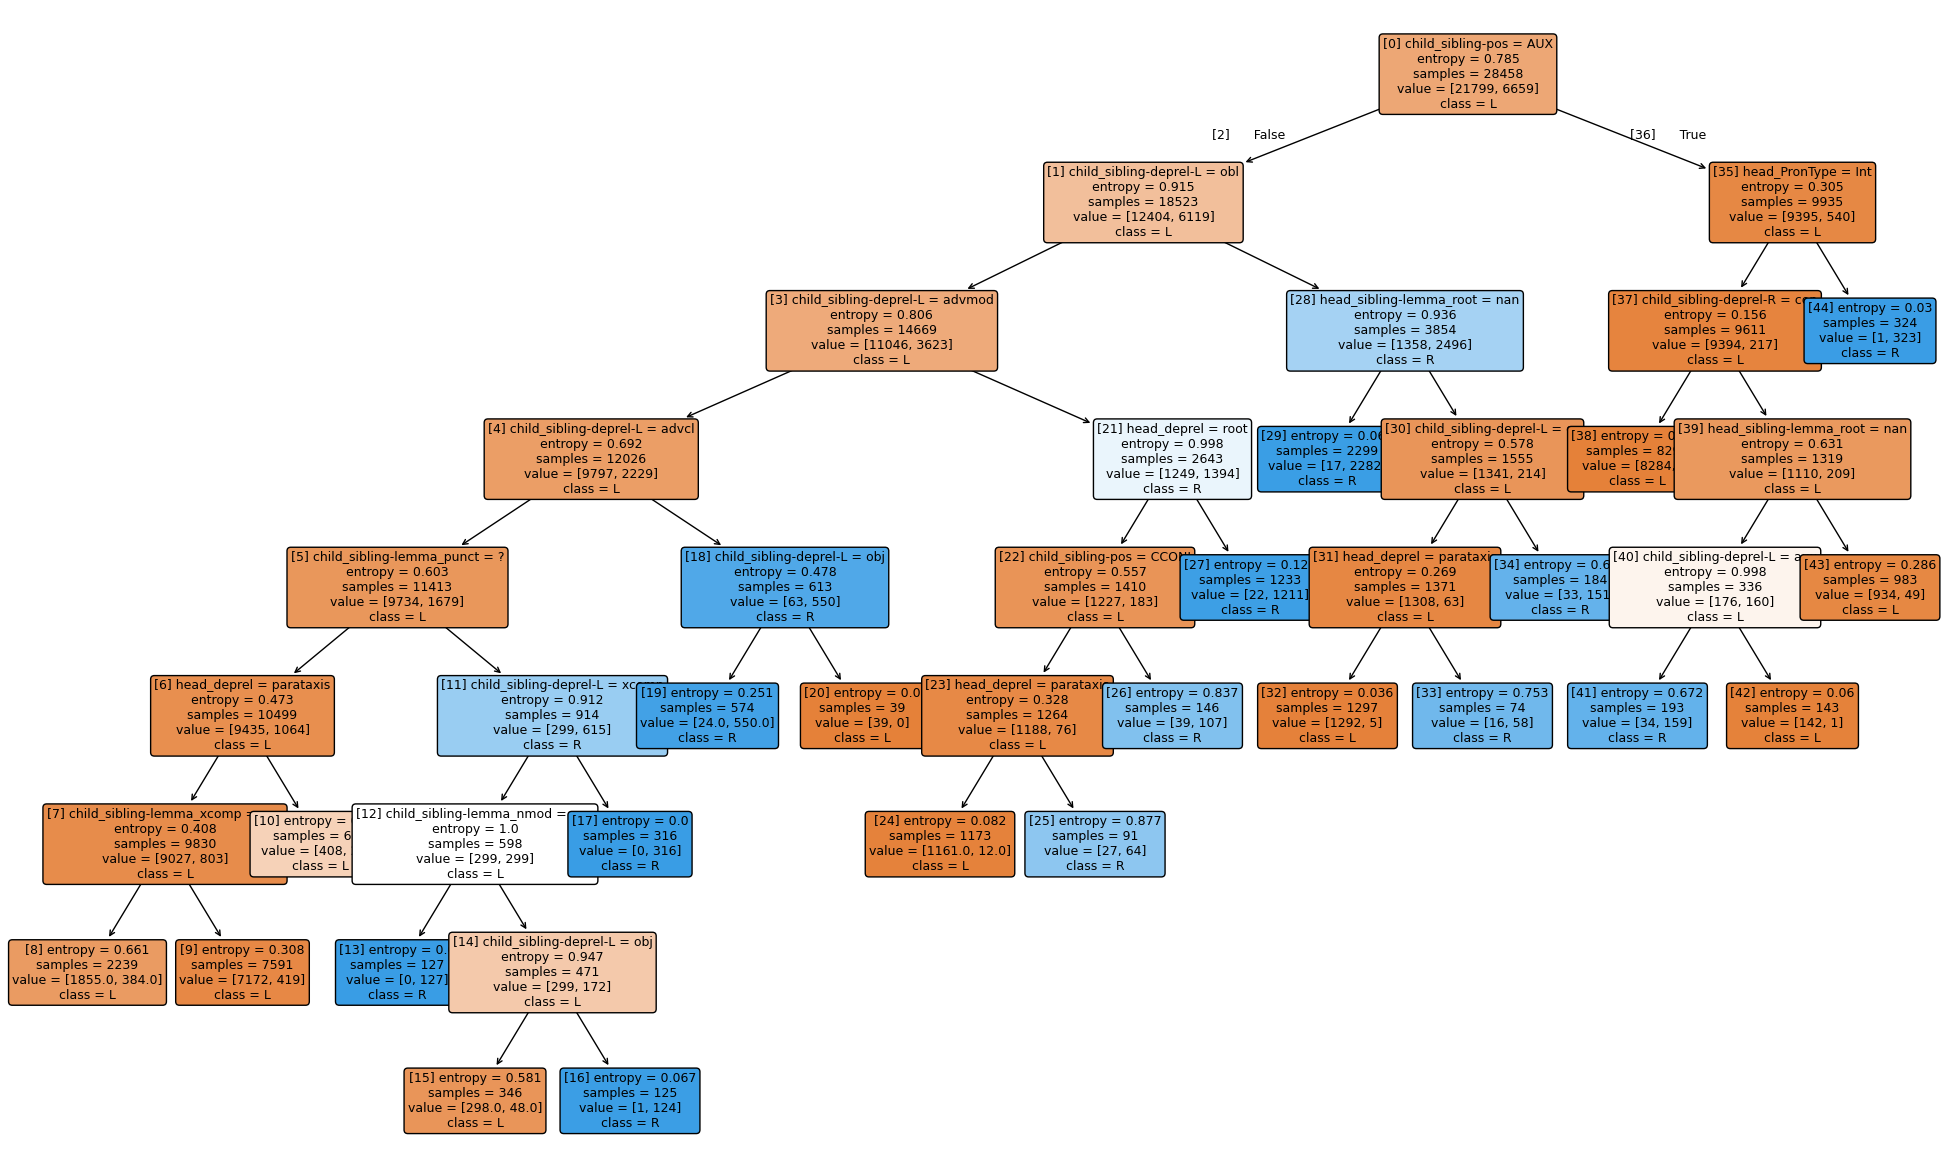

In [42]:
plot_dt(model)

In [23]:
lang2entropy = {}

# langs = get_ud_langs("resources")
word_order_dir = "/media/jaap/81b6ce8a-28e5-4eda-9c68-b13e0637cc4f/word_order_df/"
for lang in tqdm_notebook(langs, total=len(langs)):
    if lang in lang2entropy:
        continue

    df = read_df(lang, word_order_dir=word_order_dir)

    if len(df) > 0:
        deprel_entropy = calc_dep_entropy(df)
        lang2entropy[lang] = deprel_entropy

/tmp/ipykernel_474453/3215825106.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lang in tqdm_notebook(langs, total=len(langs)):


  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
np.mean(all_base_entropy), np.mean(all_model_entropy), np.mean(all_base_entropy - all_model_entropy)

(np.float64(0.4854606645435053),
 np.float64(0.3071973487516613),
 np.float64(0.17826331579184387))

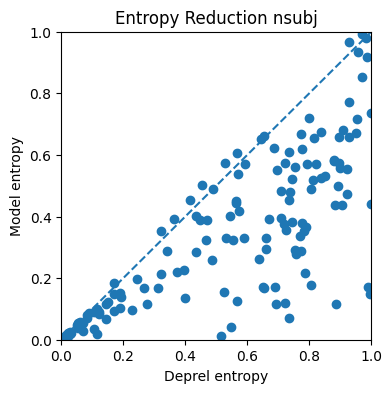

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(
    all_base_entropy,
    all_model_entropy,
)
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("Deprel entropy")
plt.ylabel("Model entropy")
plt.title(f"Entropy Reduction {deprel}")

plt.plot([0,1],[0,1],ls='--')

In [106]:
from scipy.stats import spearmanr

ent_df = pd.DataFrame.from_dict(lang2entropy).transpose()

x = 'nsubj'
y = 'obj'

df = ent_df[~ent_df[x].isna() & ~ent_df[y].isna()]
# df = df[df[y] > 0]

plt.figure(figsize=(5,5))

sns.regplot(
    data=df,
    x=x,
    y=y,
    scatter_kws={'alpha': 0.5, 'color': 'salmon'},
    # alpha=0.5,
)

plt.title("Dependency Entropy")
plt.text(0, 1, f"$r={pearsonr(df[x], df[y])[0]:.2f}$")

NameError: name 'pd' is not defined

In [78]:
# df2 = df[df.deprel == 'nsubj']

# feature = "Gender"
# feature = "Number"

# sub_df = df2[
#     (df2.child_pos == "NOUN") 
#     & (df2.head_pos == "VERB") 
#     # & (df2.head_VerbForm == "Part")
#     & (~df2[f"child_{feature}"].isna()) 
#     & (~df2[f"child_{feature}"].isna())
# ]

# sub_df['has_agr'] = sub_df[f"child_{feature}"] == sub_df[f"head_{feature}"]

# sub_df['has_agr'].mean(), len(sub_df)

In [114]:
for _, row in swap_df[:10].iterrows():
    print("+", row.sen_str)
    print("-", row.swapped_sen_str)
    print()

+ Op het programma staan een kleurenshow in Munchen , een tournee door Europa en een reisje naar Amerika in februari om te zien wat ik daar kan gaan doen . "
- Op het programma staan een kleurenshow in Munchen , een tournee door Europa en een reisje naar Amerika in februari om te zien ik daar kan gaan doen wat . "

+ Eind van het jaar 1940 moesten de Joodse mensen zich bij het bevolkingsregister laten registreren .
- Eind van het jaar 1940 moesten de Joodse mensen bij het bevolkingsregister laten registreren zich .

+ Maar begin 1863 waren opeens een aantal mensen op sleutelposities in Lee's hiërarchie omgekomen -- met name Lee's steun en toeverlaat , de excentrieke , niets-en-niemand ontziende Thomas " Stonewall " Jackson .
- Maar begin 1863 waren opeens een aantal mensen op sleutelposities in Lee's hiërarchie omgekomen -- met name Lee's steun en toeverlaat , de excentrieke , ontziende niets-en-niemand Thomas " Stonewall " Jackson .

+ Drie andere lichte geallieerde cavaleriebrigades 

In [35]:
import tempfile

from tqdm import tqdm_notebook
from transformers import AutoModelForCausalLM, AutoTokenizer
from minicons import scorer

import pandas as pd
import os

import dotenv


def load_hf_model(model_name: str, no_cache=False, **kwargs):
    model = None
    tokenizer = None
    token = dotenv.load_dotenv()["HF_TOKEN"]
    kwargs["token"] = token
    
    try:
        if no_cache:
            with tempfile.TemporaryDirectory() as tmpdirname:
                model = AutoModelForCausalLM.from_pretrained(
                    model_name, cache_dir=tmpdirname, **kwargs
                )
                tokenizer = AutoTokenizer.from_pretrained(
                    model_name, cache_dir=tmpdirname, **kwargs
                )
        else:
            model = AutoModelForCausalLM.from_pretrained(model_name, **kwargs)
            tokenizer = AutoTokenizer.from_pretrained(model_name, **kwargs)
    except OSError:
        pass

    if model is None:
        return None

    ilm_model = scorer.IncrementalLMScorer(
        model,
        "cuda",
        tokenizer=tokenizer,
    )

    return ilm_model


def score_tse(model, tse_df, sen="sen", wrong_sen="wrong_sen"):
    tse_df["sen_prob"] = pd.Series(dtype=object).astype(object)
    tse_df["wrong_prob"] = pd.Series(dtype=object).astype(object)

    max_length = None  # ilm_model.model.transformer.config.n_ctx

    for idx, row in tqdm_notebook(tse_df.iterrows(), total=len(tse_df)):
        sen_prob, wrong_prob = score_pair(model, row[sen], row[wrong_sen], max_length)

        sen_nll = -sen_prob.sum().item()
        wrong_nll = -wrong_prob.sum().item()

        tse_df.at[idx, "sen_prob"] = sen_prob.tolist()
        tse_df.at[idx, "wrong_prob"] = wrong_prob.tolist()

        tse_df.loc[idx, "sen_nll"] = sen_nll
        tse_df.loc[idx, "wrong_nll"] = wrong_nll
        tse_df.loc[idx, "delta"] = wrong_nll - sen_nll

    return tse_df


def score_pair(ilm_model, sen, wrong_sen, max_length):
    sen_len = len(ilm_model.tokenizer.tokenize(sen))
    wrong_sen_len = len(ilm_model.tokenizer.tokenize(wrong_sen))

    if (max_length is not None) and (
        (sen_len >= max_length) or (wrong_sen_len >= max_length)
    ):
        return 0.0, 0.0

    stimuli = [sen, wrong_sen]

    return ilm_model.sequence_score(stimuli, reduction=lambda x: x)

In [23]:
# llm = load_hf_model("Qwen/Qwen3-0.6B", no_cache=True)
llm = load_hf_model("google/gemma-3-1b-pt", no_cache=False)

In [115]:
df = score_tse(llm, swap_df, sen="sen_str", wrong_sen="swapped_sen_str")

/tmp/ipykernel_5438/2172443211.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tse_df["sen_prob"] = pd.Series(dtype=object).astype(object)
/tmp/ipykernel_5438/2172443211.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tse_df["wrong_prob"] = pd.Series(dtype=object).astype(object)
/tmp/ipykernel_5438/2172443211.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, row in tqdm_notebook(tse_df.iterrows(), total=len(tse_df)):


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_5438/2172443211.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tse_df.loc[idx, "sen_nll"] = sen_nll
/tmp/ipykernel_5438/2172443211.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tse_df.loc[idx, "wrong_nll"] = wrong_nll
/tmp/ipykernel_5438/2172443211.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

In [116]:
swap_df['pred'] = swap_df.delta > 0
swap_df['pred'].mean()

/tmp/ipykernel_5438/1073161291.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  swap_df['pred'] = swap_df.delta > 0


np.float64(0.9518072289156626)

In [89]:
swap_df.groupby("leaf_id").mean("pred")

,head_sibling-deprel-L_dislocated,head_sibling-deprel_dep,child_sibling-deprel_aux,child_sibling-deprel-R_xcomp,head_sibling-deprel-L_cop,child_sibling-deprel-L_dep:der,child_sibling-deprel-L_csubj:cop,head_sibling-deprel_cop,under_dep:der,in_question,...,child_idx,tree_idx,head_idx,dir,leaf_entropy,leaf_decision,sen_nll,wrong_nll,delta,pred
leaf_id,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.000000,0.064516,0.0,0.0,0.0,0.0,0.000000,0.0,0.225806,...,5.967742,4574.258065,7.967742,0.0,0.0,1.0,108.306404,115.684361,7.377956,0.903226
16,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.080000,0.0,0.010000,...,8.350000,4661.580000,10.340000,0.0,0.0,1.0,134.290270,147.283970,12.993700,0.950000
21,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.000000,0.0,0.227273,...,6.727273,4709.545455,8.409091,0.0,0.0,1.0,116.670452,123.534769,6.864317,0.863636
22,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,7.230000,4763.340000,8.390000,0.0,0.0,1.0,87.897517,91.265219,3.367702,0.690000
25,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.010000,0.0,0.030000,...,6.230000,4928.080000,8.110000,0.0,0.0,1.0,109.640864,122.693644,13.052780,0.970000
27,0.0,0.010000,0.000000,0.0,0.0,0.0,0.0,0.070000,0.0,0.000000,...,7.210000,4777.270000,8.600000,0.0,0.0,1.0,141.357241,153.763556,12.406315,0.970000
30,0.0,0.010204,0.000000,0.0,0.0,0.0,0.0,0.061224,0.0,0.000000,...,11.897959,5015.479592,13.734694,0.0,0.0,1.0,171.066267,183.959427,12.893160,1.000000
34,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,...,7.600000,5030.920000,9.400000,0.0,0.0,1.0,112.287519,124.195799,11.908280,0.980000
40,0.0,0.000000,0.050000,0.0,0.0,0.0,0.0,0.025000,0.0,0.075000,...,5.525000,5429.800000,7.375000,0.0,0.0,1.0,118.418534,128.910697,10.492162,1.000000


In [90]:
Counter(swap_df.leaf_id)

Counter({16: 100,
         22: 100,
         25: 100,
         27: 100,
         34: 100,
         30: 98,
         40: 40,
         13: 31,
         21: 22})

In [91]:
{x:y for x, y in leaf_rules.items() if x in swap_df.leaf_id.unique()}

{np.int64(34): ['child_PronType != Prs',
  'treebank_UD = Turkish-Penn',
  'head_lemma != ver'],
 np.int64(16): ['child_PronType != Prs',
  'treebank_UD != Turkish-Penn',
  'child_sibling-lemma_punct != ,',
  'head_Person != None',
  'child_sibling-lemma_advmod != çok',
  'head_Polarity != None',
  'treebank_UD != Turkish-Atis',
  'head_Person != 2',
  'head_Aspect = None'],
 np.int64(25): ['child_PronType != Prs',
  'treebank_UD != Turkish-Penn',
  'child_sibling-lemma_punct != ,',
  'head_Person != None',
  'child_sibling-lemma_advmod != çok',
  'head_Polarity = None',
  'child_sibling-lemma_compound:lvc = None'],
 np.int64(21): ['child_PronType != Prs',
  'treebank_UD != Turkish-Penn',
  'child_sibling-lemma_punct != ,',
  'head_Person != None',
  'child_sibling-lemma_advmod != çok',
  'head_Polarity != None',
  'treebank_UD != Turkish-Atis',
  'head_Person = 2',
  'child_sibling-deprel-L = obl'],
 np.int64(30): ['child_PronType != Prs',
  'treebank_UD != Turkish-Penn',
  'child_sib

In [78]:
swap_df[swap_df.delta < 2].iloc[5].delta

np.float64(-3.135345458984375)

In [94]:
idx = 0
for _, row in swap_df[swap_df.delta < -1].iterrows():
    # print("P(+) > P(-):\t", np.round(row.delta, 3))
    print(f"P(+): {row.sen_nll:.2f}\t", row.sen_str)
    print(f"P(-): {row.wrong_nll:.2f}\t", row.swapped_sen_str)
    print()

    idx += 1
    if idx > 10:
        break

P(+): 189.43	 Ben de börekleri haliyle pencereden dışarıya altımızda ki zemin katında yatan adi mahpusların gezindikleri yere savurup attım ."
P(-): 186.74	 Ben de haliyle pencereden dışarıya altımızda ki zemin katında yatan adi mahpusların gezindikleri yere savurup attım börekleri ."

P(+): 69.65	 " Alex'le para konuşmadık "
P(-): 67.60	 " Alex'le konuşmadık para "

P(+): 65.42	 Kalem alıp kaşın gözün yazmalı
P(-): 62.81	 Kalem alıp yazmalı kaşın gözün

P(+): 104.95	 Ve sen o kokmuş tangoyu on sekizinci defa dinleyeceksin .
P(-): 101.60	 Ve sen on sekizinci defa dinleyeceksin o kokmuş tangoyu .

P(+): 127.12	 Oyuna bir de kalender , feleğin çemberinden geçmiş ihtiyar komiser koyacaksınız .
P(-): 125.23	 Oyuna koyacaksınız bir de kalender , feleğin çemberinden geçmiş ihtiyar komiser .

P(+): 107.76	 bana Boston'dan San Francisco'ya öğleden sonra 1'den önce varacak uçuşları göster
P(-): 101.22	 bana göster Boston'dan San Francisco'ya öğleden sonra 1'den önce varacak uçuşları

P(+): 68.3

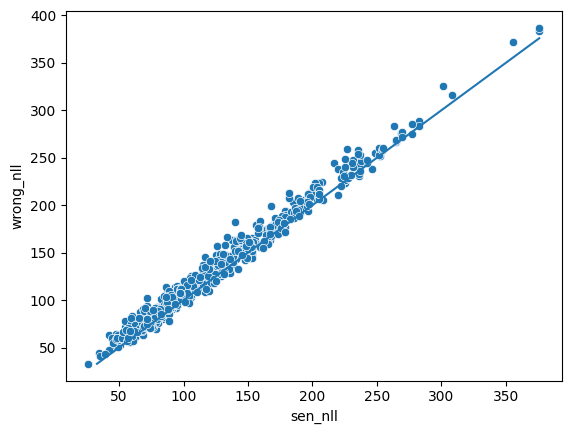

Text(0.5, 0, 'P(+) > P(-)')

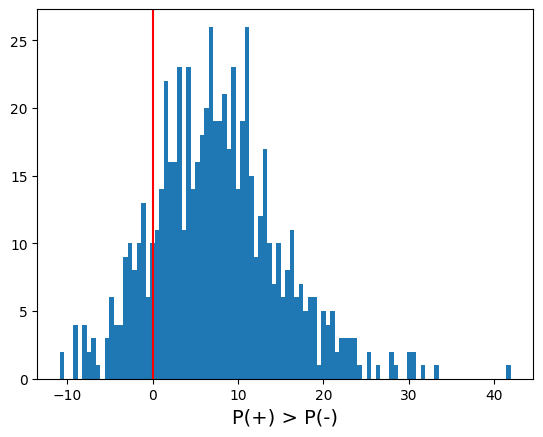

In [42]:
import seaborn as sns

sns.scatterplot(
    data=swap_df,
    x='sen_nll',
    y='wrong_nll',
)
plt.plot([min(swap_df['wrong_nll']), max(swap_df['sen_nll'])], [min(swap_df['wrong_nll']), max(swap_df['sen_nll'])])
plt.show()

plt.hist(
    swap_df.delta,
    100,
)
plt.axvline(0, color='red')
plt.xlabel("P(+) > P(-)", fontsize=14)

In [390]:
deprel = 'obj'
case = 'Acc'

sub_df = df[(df.deprel==deprel) & (df.head_pos == "VERB")]

print(f"{'treebank':<20}", "n", f"% {case} --[{deprel}]--> VERB", sep='\t')
for tb, df2 in sub_df.groupby("treebank"):
    df2 = df2[~pd.isna(df2).child_Case]
    pct = 100*Counter(df2.child_Case)[case] / sum(Counter(df2.child_Case).values())
    print(f"{tb:<20}", sum(Counter(df2.child_Case).values()), f"{pct:.1f}", sep='\t')

treebank            	n	% Acc --[obj]--> VERB
UD_Turkish-Atis     	2335	31.9
UD_Turkish-BOUN     	6103	81.0
UD_Turkish-FrameNet 	1070	56.4
UD_Turkish-GB       	1115	61.2
UD_Turkish-IMST     	3000	55.7
UD_Turkish-Kenet    	6297	41.2
UD_Turkish-PUD      	333	80.8
UD_Turkish-Penn     	4720	40.8
UD_Turkish-Tourism  	2115	27.3
UD_Turkish-TueCL    	59	57.6


In [387]:
for _, item in sub_df[sub_df.child_Case == "Acc"].iterrows():
    if len(item.sen) < 10:
        print(item.child_form, item.sent_id, item.treebank, ' '.join(item.sen), sep='\t')
        break

ulaşımını	0011.train	UD_Turkish-Atis	Şimdi bana pazartesi öğlen Houston'daki karayolu ulaşımını göster


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


RND = 42

sub_df = df[(df.deprel=="obj") & (df.head_pos == "VERB")]

omit_feats = {"head_lemma", "child_lemma", "head_form", "child_form", "head_Number"}
omit_feats = set()
SUB_CONDITION_ON = list(set(CONDITION_ON) - omit_feats)
# SUB_CONDITION_ON = ["in_question", "under_acl", "head_VerbForm", "head_deprel"]

X = sub_df.drop(["sen", "dir"], axis=1)
X = sub_df[SUB_CONDITION_ON]
y = sub_df["dir"]

numeric_cols = [
    feat for feat in SUB_CONDITION_ON 
    if (
        "freq" in feat 
        or (feat == "num_siblings")
        or ("under" in feat)
        or "question" in feat
    )
]
categorical_cols = list(set(SUB_CONDITION_ON) - set(numeric_cols))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RND)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        criterion="entropy", 
        random_state=RND,
        # max_depth=5,
        # min_samples_leaf=25,
        # min_impurity_decrease=0.01,
        # ccp_alpha=0.01,
    ))
])

model.fit(X_train, y_train)

print("Train acc", model.score(X_train, y_train))
print("Test acc ", model.score(X_test, y_test))

Train acc 0.9997700268302031
Test acc  0.9772413793103448


In [44]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")


RND = 42

sub_df = df[(df.deprel=="obj") & (df.head_pos == "VERB")]

omit_feats = {"head_lemma", "child_lemma", "head_form", "child_form", "head_Number"}
omit_feats = set()
SUB_CONDITION_ON = list(set(CONDITION_ON) - omit_feats)
# SUB_CONDITION_ON = ["in_question", "under_acl", "head_VerbForm", "head_deprel"]

X = sub_df.drop(["sen", "dir"], axis=1)
X = sub_df[SUB_CONDITION_ON]
y = sub_df["dir"]

numeric_cols = [
    feat for feat in SUB_CONDITION_ON 
    if (
        "freq" in feat 
        or (feat == "num_siblings")
        or ("under" in feat)
        or "question" in feat
    )
]
categorical_cols = list(set(SUB_CONDITION_ON) - set(numeric_cols))

for col in categorical_cols:
    X[col] = X[col].astype('category')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RND)

model = LGBMClassifier(
    objective='multiclass' if len(y.unique()) > 2 else 'binary',
    max_depth=5,
    min_child_samples=25,        # similar to min_samples_leaf
    min_split_gain=0.01,          # similar to min_impurity_decrease
    random_state=RND,
    n_estimators=3,              # number of trees
    verbose=-1,
)

# Fit the model, passing categorical features directly
model.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)

# Evaluate
print("Train acc", model.score(X_train, y_train))
print("Test acc ", model.score(X_test, y_test))

Train acc 0.9617477960904561
Test acc  0.9779310344827586


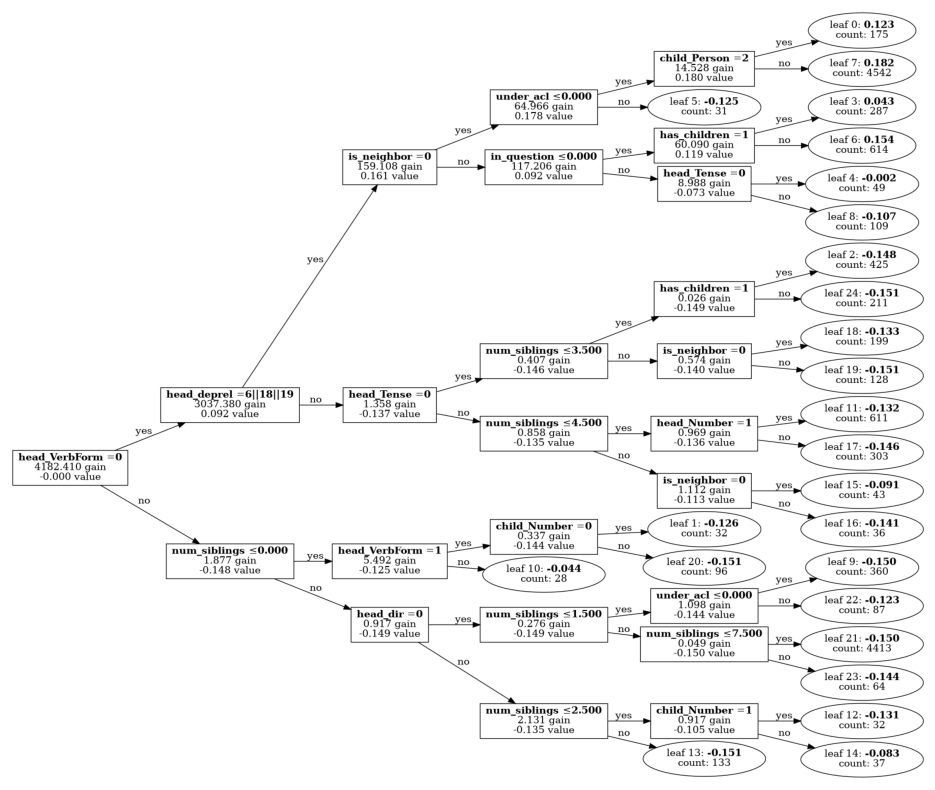

In [46]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Create a booster object from the fitted model
booster = model.booster_

# Plot the first tree (index 0)
ax = lgb.plot_tree(
    booster, 
    tree_index=2, 
    figsize=(20, 10), 
    show_info=['split_gain', 'internal_value', 'leaf_count', 'entropy']
)
plt.show()

In [17]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import pandas as pd

def plot_lgb_tree_pretty(model, X_train, tree_index=0):
    """
    Print a LightGBM tree with categorical labels instead of integer codes.
    """
    booster = model.booster_
    tree = booster.dump_model()['tree_info'][tree_index]['tree_structure']
    feature_names = X_train.columns.tolist()

    # Build mapping for categorical columns
    cat_mappings = {}
    for col in X_train.select_dtypes(['category']).columns:
        cat_mappings[col] = dict(enumerate(X_train[col].cat.categories))

    def recurse(node, depth=0):
        indent = "  " * depth
        # Internal node
        if 'split_index' in node:
            feature = feature_names[node['split_feature']]
            threshold = node['threshold']
            split_cat = None
            if node.get('decision_type') == '==':
                if feature in cat_mappings:
                    codes = [int(x) for x in str(threshold).split('||')]
                    labels = [cat_mappings[feature][c] for c in codes]
                    split_cat = labels
            if split_cat:
                print(f"{indent}[{feature} in {split_cat}]")
            else:
                print(f"{indent}[{feature} <= {threshold:.3f}]")
            recurse(node['left_child'], depth+1)
            recurse(node['right_child'], depth+1)
        # Leaf node
        else:
            samples = node.get('leaf_count', node.get('internal_count', 'N/A'))
            print(f"{indent}Leaf: value={node['leaf_value']:.3f}, samples={samples}")

    recurse(tree)


# -------------------------------
# Example usage

# Ensure categorical columns are of dtype 'category'
for col in categorical_cols:
    X_train.loc[:, col] = X_train[col].astype('category')

# Fit LightGBM
model = lgb.LGBMClassifier(max_depth=5, min_child_samples=25, min_split_gain=0.01, random_state=RND)
model.fit(X_train, y_train, categorical_feature=categorical_cols)

# Pretty tree plot in console
plot_lgb_tree_pretty(model, X_train, tree_index=0)

[head_VerbForm in ['Fin']]
  [head_deprel in ['conj', 'parataxis', 'root']]
    [under_acl <= 0.000]
      [in_question <= 0.000]
        Leaf: value=-0.133, samples=5239
        Leaf: value=-0.214, samples=507
      Leaf: value=-0.500, samples=61
    [under_acl <= 0.000]
      Leaf: value=-0.507, samples=760
      [in_question <= 0.000]
        Leaf: value=-0.511, samples=1127
        Leaf: value=-0.521, samples=69
  [head_VerbForm in ['Inf']]
    Leaf: value=-0.519, samples=3814
    [under_acl <= 0.000]
      [in_question <= 0.000]
        Leaf: value=-0.516, samples=1105
        Leaf: value=-0.521, samples=47
      Leaf: value=-0.509, samples=316


/tmp/ipykernel_53613/3435164525.py:55: RuntimeWarning: invalid value encountered in divide
  ratios = np.zeros((num_langs, len(deprels))) / 0


Text(0.5, 1.0, 'Word order entropy')

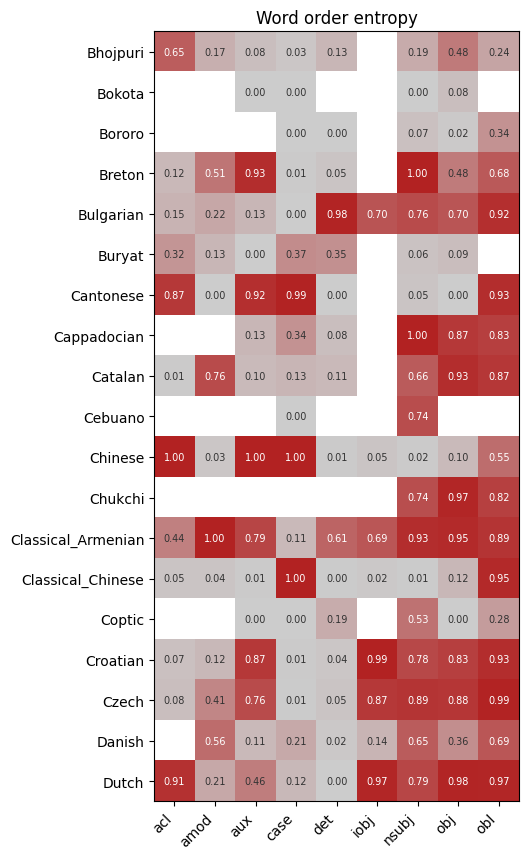

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


def order_entropy(n_ab, n_ba):
    """
    Compute Shannon entropy (in bits) for word order frequencies.
    
    Args:
        n_ab (int): Count of A>B order
        n_ba (int): Count of B>A order
    
    Returns:
        float: Entropy in bits
    """
    total = n_ab + n_ba
    if total == 0:
        return 0.0  # no data
    
    p_ab = n_ab / total
    p_ba = n_ba / total
    
    # avoid log(0) issues
    def safe_term(p):
        return -p * math.log2(p) if p > 0 else 0.0
    
    return safe_term(p_ab) + safe_term(p_ba)

# Define your two colors
color1 = "0.8"  # blue
color2 = "firebrick"  # orange

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

sub_langs = list(all_deprel_dirs.keys())[1:40]
num_langs = len(sub_langs)
min_count = 100

deprels = ["acl", "amod", "aux", "case", "det", "iobj", "nsubj", "obj", "obl"]

# contains_deprel = ["nsubj"]
# contains_head_pos = ["VERB"]
# deprels = set()
# for deprel_directions in all_deprel_dirs.values():
#     for deprel, counts in deprel_directions.items():
#         if (sum(counts) > min_count) and deprel[0] in contains_deprel and deprel[2] in contains_head_pos:
#             deprels.add(deprel)

# deprels = sorted(deprels)

ratios = np.zeros((num_langs, len(deprels))) / 0

# plt.figure(figsize=(20, 10))
plt.figure(figsize=(5, 10))

for i, lang in enumerate(sub_langs):
    for j, deprel in enumerate(deprels):
        if sum(all_deprel_dirs[lang][deprel]) > min_count:
            # ratios[i, j] = all_deprel_dirs[lang][deprel][0] / sum(all_deprel_dirs[lang][deprel])
            ratios[i, j] = order_entropy(all_deprel_dirs[lang][deprel][0], all_deprel_dirs[lang][deprel][1])
            
            cell_text = f"{ratios[i, j]:.2f}"
            plt.text(
                j,i, 
                cell_text,
                ha="center", 
                va="center", 
                color=("w" if (ratios[i, j] > 0.5) else "0.2"), 
                fontsize=7
            )

plt.imshow(
    ratios,
    clim=(0,1),
    cmap=cmap,
)
plt.xticks(range(len(deprels)), deprels, rotation=45)
plt.yticks(range(num_langs), sub_langs)

for label in plt.gca().get_xticklabels():
    label.set_ha("right")   # left, center, or right

# plt.colorbar(label="child<head entropy")
plt.title("Word order entropy")